In [50]:
import pandas as pd
import constants
from countryinfo import CountryInfo
import geonamescache
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('seaborn-bright')

gc = geonamescache.GeonamesCache()



In [41]:
populations = gc.get_countries()

from geonamescache.mappers import country as countrywrapper


def get_population_for_country(countryname):
    mapper = countrywrapper(from_key='name', to_key='iso')
    iso3 = mapper(countryname)
    if(iso3==None):
        return 1
    return populations[iso3]['population']
    

In [42]:
#from https://github.com/willhaslett/covid-19-growth/blob/master/lib/c19all.py
def df_from_csv(file_name):
    df = pd.read_csv(file_name,sep=',')
    df = df.rename(columns=constants.RENAMED_COLUMNS)
    date_cols = df.filter(regex=('^\d+/\d+/\d+$')).columns.array
    df = pd.melt(df, id_vars=['province_state', 'country', 'lat',
                                      'long'], value_vars=date_cols, var_name='date', value_name='cases')
    df.date = pd.to_datetime(df.date, format='%m/%d/%y')
    df['day'] = (df.date - pd.to_datetime(df.date.iloc[0])).astype('timedelta64[D]')
    df.day = df.day.apply(lambda day: int(round(day)))
    return df[['date', 'day', 'cases', 'province_state', 'country', 'lat', 'long']]

# General purpose filter.
def filter(df, column, value):
    return df[df[column] == value].reset_index()

# Filter on country
def for_country_per_day(df, country):
    return filter(df, 'country', country).groupby("date").sum()
eu_list = ['Austria','Belgium','Bulgaria',
'Croatia','Cypru','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia','Spain','Sweden']

styles = ['bs-',
          'rs-', 
          'ys-', 
          'gs-', 
          'bo-',
          'ro-', 
          'yo-', 
          'go-',
          'b^-',
          'r^-', 
          'y^-', 
          'g^-',
          'b--',
          'r--', 
          'y--', 
          'g--']

In [43]:
confirmed = df_from_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
death = df_from_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
recovered = df_from_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

In [44]:
confirmed = confirmed[confirmed.country != "Cruise Ship"]

countrypop = {}
for count in confirmed.country.unique():
    countrypop[count] = get_population_for_country(count)
    
#we map instead of applying the function to reduce computational cost
confirmed["population"] = confirmed['country'].map(countrypop)
confirmed["cases_per_capita"] = confirmed["cases"]/confirmed["population"]

death = death[death.country != "Cruise Ship"]
    
#we map instead of applying the function to reduce computational cost
death["population"] = death['country'].map(countrypop)
death["cases_per_capita"] = death["cases"]/death["population"]

recovered = recovered[recovered.country != "Cruise Ship"]
    
#we map instead of applying the function to reduce computational cost
recovered["population"] = recovered['country'].map(countrypop)
recovered["cases_per_capita"] = recovered["cases"]/recovered["population"]

In [59]:
f, main_ax = plt.subplots()

f.set_figheight(10)
f.set_figwidth(20)

#Top 10 countries with confirmed cases per capita
top10 = confirmed[confirmed["country"].isin(eu_list+["China"])].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

confirmed_countries = confirmed[confirmed["country"].isin(top10)].groupby(["date","country"]).sum()

confirmed_countries.unstack(level=1)["cases_per_capita"].plot(ax=main_ax,style=styles)
main_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
main_ax.set_title("Top 10 EU+CHINA countries with most confirmed cases per capita")
main_ax.xaxis.set_major_locator(mdates.DayLocator())
 main_ax.xaxis.set_minor_locator(mdates.DayLocator())

## Rotate date labels automatically

plt.grid()

IndentationError: unexpected indent (<ipython-input-59-77e89a65da85>, line 15)

In [35]:
confirmed[confirmed["country"].isin(eu_list)].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

array(['Italy', 'Denmark', 'Spain', 'Sweden', 'Luxembourg', 'Austria',
       'Estonia', 'Slovenia', 'France', 'Belgium'], dtype=object)

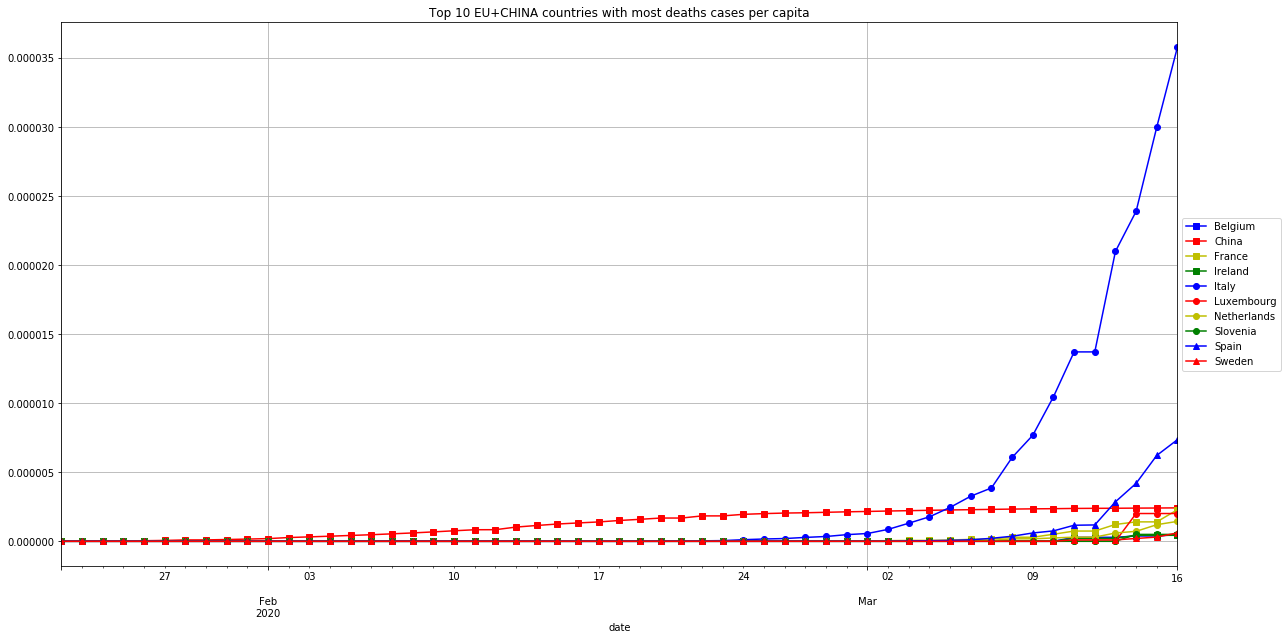

In [37]:
f, main_ax = plt.subplots()

f.set_figheight(10)
f.set_figwidth(20)

#Top 10 countries with confirmed cases per capita
top10 = death[death["country"].isin(eu_list+["China"])].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

death_countries = death[death["country"].isin(top10)].groupby(["date","country"]).sum()

death_countries.unstack(level=1)["cases_per_capita"].plot(ax=main_ax,style=styles)
main_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
main_ax.set_title("Top 10 EU+CHINA countries with most deaths cases per capita")
plt.grid()

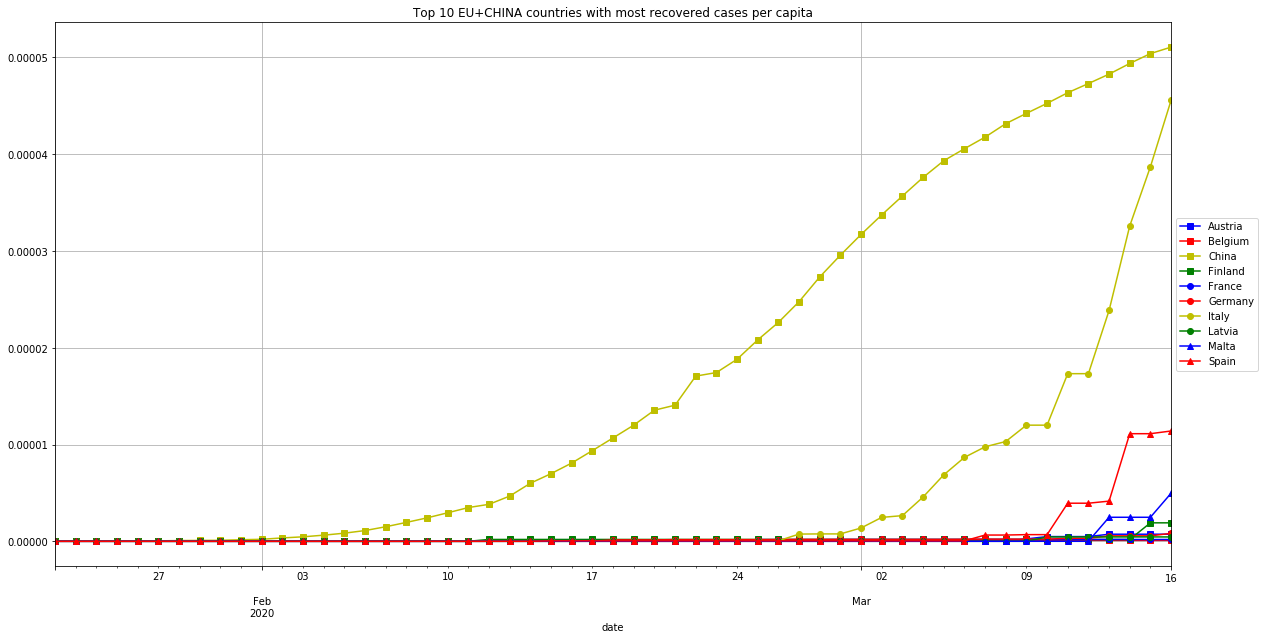

In [28]:
f, main_ax = plt.subplots()

f.set_figheight(10)
f.set_figwidth(20)

#Top 10 countries with confirmed cases per capita
top10 = recovered[recovered["country"].isin(eu_list + ["China"])].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

recovered_countries = recovered[recovered["country"].isin(top10)].groupby(["date","country"]).sum()

recovered_countries.unstack(level=1)["cases_per_capita"].plot(ax=main_ax,style=styles)
main_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
main_ax.set_title("Top 10 EU+CHINA countries with most recovered cases per capita")
plt.grid()